In [1]:
## Connect to drive to access drive data and storage
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Problem Statement : Machine Learning Engineering Challenge

  - **Goal**: Build a machine learning model and deploy it.
  - **Task**: Develop a machine learning model (image classification) based on provided data and deploy it as a simple web application or API.
  - **Output**: A GitHub repository with code, usage documentation and a live demo (could be a simple web page).
  - **Evaluation**: Performance of the model, code quality, and usability of the deployment.

  - **Data**: https://www.cs.toronto.edu/~kriz/cifar.html (use the CIFAR-10 version)



##### Required library imports

In [2]:
## Importing Pytorch
import torch
print(torch.__version__)

2.2.1+cu121


In [3]:
## Libraries needed from pytorch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

1. Pytorch **Dataset** is an object that is required to implement two methods: __len__ and __getitem__. The former should return the number of items in the dataset; the latter should return the item, consisting of a sample and its corresponding label (an integer index).
2. The **torchvision** package consists of popular datasets, model architectures, and common image transformations for computer vision applications.



##### Downloading the data using **torchvision.datasets**

In [4]:
## CIFAR 10 version data is available in torchvision datasets. We can download the dataset directly from here.
data_folder = '../data/CIFAR10/train'
cifar10 = datasets.CIFAR10(data_folder, train=True, download=True)
tr_images = cifar10.data
tr_targets = cifar10.targets
print(type(tr_images),type(tr_targets))

100%|██████████| 170498071/170498071 [00:12<00:00, 13118110.26it/s]


Extracting ../data/CIFAR10/train/cifar-10-python.tar.gz to ../data/CIFAR10/train
<class 'numpy.ndarray'> <class 'list'>


In [5]:
data_folder = '~/data/CIFAR10/val'
cifar10_val = datasets.CIFAR10(data_folder, train=False, download=True)
val_images = cifar10_val.data
val_targets = cifar10_val.targets
print(type(val_images),type(val_targets))

100%|██████████| 170498071/170498071 [00:12<00:00, 13160687.30it/s]


Extracting /root/data/CIFAR10/val/cifar-10-python.tar.gz to /root/data/CIFAR10/val
<class 'numpy.ndarray'> <class 'list'>


In [6]:
## Information from data
unique_values = set(tr_targets)
print(f'tr_images & tr_targets:\n\tX : {tr_images.shape}\n\tY \: {len(tr_targets)}\n\tY-Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{cifar10.classes}')

tr_images & tr_targets:
	X : (50000, 32, 32, 3)
	Y \: 50000
	Y-Unique Values : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
TASK:
	10 class Classification
UNIQUE CLASSES:
	['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
## Dictionary to map class name from CIFAR10 data to the labels

class_map_dict ={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

##### Visualiation of data

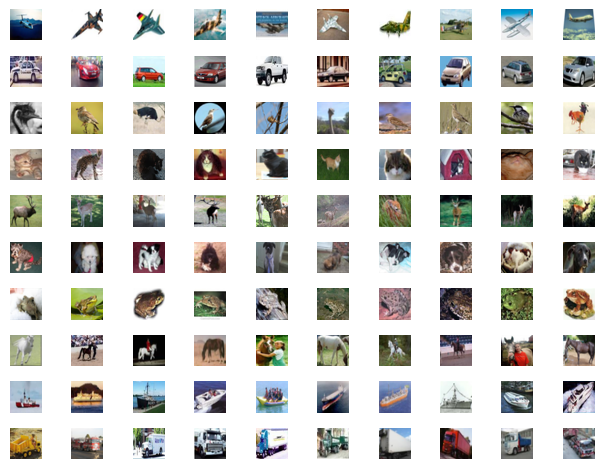

In [8]:
## Visualiation of data

## Ploting a random sample of 10 images for all the 10 classes
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
fig , axes = plt.subplots(10,10)
for label_class, plot_row in enumerate(axes):
    label_x_rows = np.where(np.asarray(tr_targets) == label_class)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x)
plt.tight_layout()

We have considerd **Dense Neural Network** and **Convolutional Neural Network** for this task along with data augmentation and regularization techniques with baseline models.

##### Dense Neural Network

In [17]:
### Dense connected network for classification
# Define the dataset and dataloaders considering the augmentation process for each image
#  in dataset only by picking random transform object from a given list

class Cifar10_dnn(Dataset):
    def __init__(self, input_images, targets,aug=None):
        self.sample = input_images
        self.targets = targets
        self.aug = aug
        self.transform = transforms.Compose([transforms.Resize(size=(32,32)),transforms.ToTensor()])
    def __getitem__(self,ndx):
        sample = self.sample[ndx]
        sample = transforms.ToPILImage()(sample)
        if self.aug is not None:
            num_objects = random.randint(0, len(self.aug))
            aug_lst = random.sample(self.aug, num_objects)
            sample = transforms.Compose(aug_lst)(sample)

        sample = self.transform(sample).to(torch.float32)
        data_sample = sample.view(sample.shape[0]*sample.shape[1]*sample.shape[2])
        class_ndx = torch.tensor(self.targets[ndx]).to(torch.long)
        return data_sample, class_ndx
    def __len__(self):
        return len(self.targets)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
cifer10_dnn = Cifar10_dnn(tr_images,tr_targets,aug=Aug_List)
train_dataloader = DataLoader(cifer10_dnn,batch_size=64,shuffle=True,pin_memory=use_cuda)

In [18]:
image,label = cifer10_dnn[10]
print(f'Sample type and shape : {type(image), image.size()} , Label type and shape: {type(label), label.size()}')

Sample type and shape : (<class 'torch.Tensor'>, torch.Size([3072])) , Label type and shape: (<class 'torch.Tensor'>, torch.Size([]))


In [19]:
batch_sample , batch_target = next(iter(train_dataloader))
print(batch_sample.shape, batch_target.shape)

torch.Size([64, 3072]) torch.Size([64])


In [20]:
cifer10_dnn = Cifar10_dnn(val_images,val_targets)
val_dataloader = DataLoader(cifer10_dnn,batch_size=64,shuffle=False,pin_memory=use_cuda)

In [21]:
batch_sample , batch_target = next(iter(val_dataloader))
print(batch_sample.shape, batch_target.shape)

torch.Size([64, 3072]) torch.Size([64])


In [22]:
### Define the network
import torch
import torch.nn as nn
from torchsummary import summary

class SubModule(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob):
        super(SubModule, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.batchnorm = nn.BatchNorm1d(output_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.batchnorm(x)
        x = self.dropout(x)
        return x

class MySequentialModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_prob):
        super(MySequentialModel, self).__init__()
        self.layer1 = SubModule(input_size, hidden_size1, dropout_prob)
        self.layer2 = SubModule(hidden_size1, hidden_size2, dropout_prob)
        self.layer3 = SubModule(hidden_size2, hidden_size3, dropout_prob)
        self.output_layer = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output_layer(x)
        return x

# Define the dimensions
input_size = 3072  # Example input size
hidden_size1, hidden_size2, hidden_size3 = 256, 128, 64  # Example hidden size
output_size = 10  # Example output size
dropout_prob = 0.15  # Example dropout probability

# Create an instance of the model
dnn_model = MySequentialModel(input_size, hidden_size1,hidden_size2,hidden_size3, output_size, dropout_prob)
print(summary(dnn_model.to(device), (input_size,), 1,'cuda'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [1, 256]         786,688
              ReLU-2                   [1, 256]               0
       BatchNorm1d-3                   [1, 256]             512
           Dropout-4                   [1, 256]               0
         SubModule-5                   [1, 256]               0
            Linear-6                   [1, 128]          32,896
              ReLU-7                   [1, 128]               0
       BatchNorm1d-8                   [1, 128]             256
           Dropout-9                   [1, 128]               0
        SubModule-10                   [1, 128]               0
           Linear-11                    [1, 64]           8,256
             ReLU-12                    [1, 64]               0
      BatchNorm1d-13                    [1, 64]             128
          Dropout-14                   

In [23]:
import logging

# Create a custom logger
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)

In [24]:
### Define the training loop
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from collections import namedtuple

log_tuple = namedtuple('log_tuple',['class_name','epoch_no','loss','accuracy'])
MATRIX_LOSS_NDX = 0
MATRIX_LABEL_NDX = 1
MATRIX_PRED_NDX = 2
MATRIX_SIZE = 3
AUG_LIST = [transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)]

# Define the dimensions
Input_size = 3072  ## Image as one dim tensor --> 3*32*32
hidden_size1, hidden_size2, hidden_size3 = 256, 128, 64
Output_size = 10
Dropout_prob = 0.20


## Implementing all important things required using class based implementation

class Training_app_dnn:
    def __init__(self,epochs,batch_size,data_aug =None,bool_l2_reg=False):
        self.use_device = torch.cuda.is_available()
        self.device = torch.device('cuda' if self.use_device else 'cpu')
        self.epochs = epochs
        self.batch_size = batch_size
        self.l2_Reg = bool_l2_reg
        self.data_aug = data_aug
        self.model = self.initModel()
        self.optim = self.initOptim()
        self.trainingSampleCount = 0
        self.trainlogs = {}
        self.vallogs = {}

    def initModel(self):
        model = MySequentialModel(Input_size, hidden_size1, hidden_size2, hidden_size3, Output_size, Dropout_prob)
        if self.use_device:
            model = model.to(self.device)
        return model

    def initOptim(self):
        if self.l2_Reg:
            optimizer = Adam(self.model.parameters(), lr = 10e-3, weight_decay=0.005)
        else:
            optimizer = Adam(self.model.parameters(), lr = 10e-3)
        return optimizer

    def initTraindl(self):
        if self.data_aug is not None:
            train_dataset = Cifar10_dnn(tr_images,tr_targets,aug=self.data_aug)
        else:
            train_dataset = Cifar10_dnn(tr_images,tr_targets)
        train_dl = DataLoader(train_dataset,self.batch_size,shuffle=True,pin_memory=self.use_device)
        return train_dl

    def initValdl(self):
        val_dataset = Cifar10_dnn(val_images,val_targets)
        val_dl = DataLoader(val_dataset,self.batch_size,shuffle=False,pin_memory=self.use_device)
        return val_dl

    def main(self):
        train_dl = self.initTraindl()
        val_dl = self.initValdl()

        for i in range(1, self.epochs+1):
            epoch_report_train = self.doTraining(train_dl)
            self.logMatrices(epoch_report_train,i,True)
            epoch_report_val = self.doValidation(val_dl)
            self.logMatrices(epoch_report_val,i,False)

    def doTraining(self,train_dl):
        self.model.train()
        trainMatrix = torch.zeros(MATRIX_SIZE,len(train_dl.dataset),device = self.device)

        for batch_ndx , batch_data in enumerate(train_dl):
            self.optim.zero_grad()
            batch_loss = self.computeBatchLoss(batch_ndx , batch_data, train_dl.batch_size,trainMatrix)

            batch_loss.backward()

            self.optim.step()

        self.trainingSampleCount += len(train_dl.dataset)
        return trainMatrix.to('cpu')

    def doValidation(self,val_dl):
        with torch.no_grad():
            self.model.eval()
            valMatrix = torch.zeros(MATRIX_SIZE,len(val_dl.dataset),device = self.device)

            for batch_ndx ,batch_data in enumerate(val_dl):
                self.computeBatchLoss(batch_ndx,batch_data,val_dl.batch_size,valMatrix)
        return valMatrix.to('cpu')

    def computeBatchLoss(self,batch_ndx,batch_data,batch_size,log_matric):
        input_t, label_t = batch_data
        input_g = input_t.to(self.device,non_blocking = True)
        label_g = label_t.to(self.device,non_blocking = True)

        logits  = self.model(input_g)
        class_prob = torch.nn.Softmax(dim=1)(logits)
        pred = torch.argmax(class_prob,dim=1)
        loss_fn = CrossEntropyLoss(reduction='none')
        batch_loss = loss_fn(logits,label_g)

        start_ndx = batch_ndx*batch_size
        end_ndx = start_ndx + label_t.size(0)
        log_matric[MATRIX_LOSS_NDX,start_ndx:end_ndx] = batch_loss.detach()
        log_matric[MATRIX_LABEL_NDX,start_ndx:end_ndx] = label_g.detach()
        log_matric[MATRIX_PRED_NDX,start_ndx:end_ndx] = pred.detach()

        return batch_loss.mean()

    def logMatrices(self,epoch_record,epoch_no,train_bool):
        trainlogs=[]
        vallogs=[]
        mask_dict_labels = {i:epoch_record[MATRIX_LABEL_NDX] == i for i in range(0,10)}
        mask_dict_pred = {i:epoch_record[MATRIX_PRED_NDX] == i for i in range(0,10)}
        ### Loss calculation
        loss_per_class = [epoch_record[MATRIX_LOSS_NDX,mask_dict_labels[i]].mean() for i in range(0,10)]
        total_loss = epoch_record[MATRIX_LOSS_NDX].mean()
        loss_per_class.append(total_loss)
        ### Accuracy calculation
        accuracy_per_class = [(int((mask_dict_labels[i] & mask_dict_pred[i]).sum())/int(mask_dict_labels[i].sum()))*100 for i in range(0,10)]
        total_accuracy = (int((epoch_record[MATRIX_LABEL_NDX] == epoch_record[MATRIX_PRED_NDX]).sum())/int((epoch_record[MATRIX_LABEL_NDX] == epoch_record[MATRIX_LABEL_NDX]).sum()))*100
        accuracy_per_class.append(total_accuracy)
        for i in range(0,11):
            if train_bool:
                trainlogs.append(log_tuple(i,epoch_no,loss_per_class[i],accuracy_per_class[i]))
            else:
                vallogs.append(log_tuple(i,epoch_no,loss_per_class[i],accuracy_per_class[i]))

        if train_bool:
            self.trainlogs[epoch_no] = trainlogs
            log.info(f'Epoch:{epoch_no} , Total Training Loss: {total_loss} and Total training Accuracy is {total_accuracy} %')
        else:
            self.vallogs[epoch_no] = vallogs
            log.info(f'Epoch:{epoch_no} , Total Validation Loss: {total_loss} and Total Validation Accuracy is {total_accuracy} %')


In [ ]:
### Training the model
model_class = Training_app_dnn(epochs=100,batch_size=1024)

In [ ]:
model_class.main()

In [ ]:
### Save the model dictonary and training logs
save_pth =  '/content/drive/MyDrive/Data_DSChallenge/Models and training logs/DNN/Baseline'
torch.save(model_class.model.state_dict(), save_pth+ '/dnn_baseline.pth')

In [ ]:
## Reload the parameters into model instance and check result on validation data
reloded_model = MySequentialModel(Input_size, hidden_size1, hidden_size2, hidden_size3, Output_size, Dropout_prob)
reloded_model.load_state_dict(torch.load(save_pth + '/dnn_baseline.pth'))

<All keys matched successfully>

In [ ]:
## Recheck the performance of saved model on validation data to be double check about
## what we have saved is exactly same as what as what model we have trained.

val_dataset = Cifar10_dnn(val_images,val_targets)
use_device = torch.cuda.is_available()
device = torch.device('cuda' if use_device else 'cpu')
batch_size = 512
val_dl = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,pin_memory=use_device)
reloded_model = reloded_model.to(device)
with torch.no_grad():
    reloded_model.eval()
    valMatrix = torch.zeros(MATRIX_SIZE,len(val_dl.dataset),device = device)
    for batch_ndx ,batch_data in enumerate(val_dl):
        input_t, label_t = batch_data
        input_g = input_t.to(device,non_blocking = True)
        label_g = label_t.to(device,non_blocking = True)
        logits  = reloded_model(input_g)
        class_prob = torch.nn.Softmax(dim=1)(logits)
        pred = torch.argmax(class_prob,dim=1)

        start_ndx = batch_ndx*batch_size
        end_ndx = start_ndx + label_t.size(0)
        valMatrix[MATRIX_LABEL_NDX,start_ndx:end_ndx] = label_g.detach()
        valMatrix[MATRIX_PRED_NDX,start_ndx:end_ndx] = pred.detach()

epoch_record = valMatrix.to('cpu')
mask_dict_labels = {i:epoch_record[MATRIX_LABEL_NDX] == i for i in range(0,10)}
mask_dict_pred = {i:epoch_record[MATRIX_PRED_NDX] == i for i in range(0,10)}
### Accuracy calculation
accuracy_per_class = [(int((mask_dict_labels[i] & mask_dict_pred[i]).sum())/int(mask_dict_labels[i].sum()))*100 for i in range(0,10)]
total_accuracy = (int((epoch_record[MATRIX_LABEL_NDX] == epoch_record[MATRIX_PRED_NDX]).sum())/int((epoch_record[MATRIX_LABEL_NDX] == epoch_record[MATRIX_LABEL_NDX]).sum()))*100
accuracy_per_class.append(total_accuracy)
print(accuracy_per_class)

[52.1, 62.1, 39.1, 36.8, 50.8, 52.1, 60.9, 56.699999999999996, 70.0, 64.8, 54.54]


In [ ]:
import copy
import pickle

train_logs = copy.deepcopy(model_class.trainlogs)
val_logs = copy.deepcopy(model_class.vallogs)
# Save the dictionary object to a file using pickle
with open(save_pth + '/dataaug_train_log.pkl', 'wb') as f:
    pickle.dump(train_logs, f)

with open(save_pth + '/dataaug_val_log.pkl', 'wb') as f:
    pickle.dump(val_logs, f)

In [ ]:
# Reload the dictionary object from the file using pickle to recheck the retrival of dictionary
with open(save_pth + '/baseline_train_log.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

# Print the reloaded dictionary object
print(loaded_dict)

{1: [log_tuple(class_name=0, epoch_no=1, loss=tensor(1.7793), accuracy=39.160000000000004), log_tuple(class_name=1, epoch_no=1, loss=tensor(1.9282), accuracy=31.06), log_tuple(class_name=2, epoch_no=1, loss=tensor(2.1571), accuracy=17.740000000000002), log_tuple(class_name=3, epoch_no=1, loss=tensor(2.2212), accuracy=5.96), log_tuple(class_name=4, epoch_no=1, loss=tensor(2.0278), accuracy=25.44), log_tuple(class_name=5, epoch_no=1, loss=tensor(1.9915), accuracy=27.82), log_tuple(class_name=6, epoch_no=1, loss=tensor(1.8415), accuracy=39.78), log_tuple(class_name=7, epoch_no=1, loss=tensor(2.0791), accuracy=29.56), log_tuple(class_name=8, epoch_no=1, loss=tensor(1.5790), accuracy=45.78), log_tuple(class_name=9, epoch_no=1, loss=tensor(1.7501), accuracy=40.300000000000004), log_tuple(class_name=10, epoch_no=1, loss=tensor(1.9355), accuracy=30.259999999999998)], 2: [log_tuple(class_name=0, epoch_no=2, loss=tensor(1.6790), accuracy=41.160000000000004), log_tuple(class_name=1, epoch_no=2, l

In [ ]:
## Ploting the graphs using matplotlib for model performance during training and validation,
## monitoring individual classes and overall performance on all classes for deeper analysis.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_curves(trainlog_dict, vallog_dict, acc_bool, name_str):
    ## data retrival
    train_data = trainlog_dict
    val_data = vallog_dict
    epochs = [num for num in train_data]
    if acc_bool:
        Allclass_train_acc = []
        Allclass_val_acc = []
        for i in range(11):
            Allclass_train_acc.append([tup.accuracy for value in train_data.values() for tup in value if tup.class_name == i])
            Allclass_val_acc.append([tup.accuracy for value in val_data.values() for tup in value if tup.class_name == i])
    else:
        Allclass_train_loss = []
        Allclass_val_loss = []
        for i in range(11):
            Allclass_train_loss.append([tup.loss for value in train_data.values() for tup in value if tup.class_name == i])
            Allclass_val_loss.append([tup.loss for value in val_data.values() for tup in value if tup.class_name == i])

    # Set up the figure and GridSpec layout
    fig = plt.figure(figsize=(17,10))
    # Create a gridspec for the first 10 subplots (2 rows, 5 columns)
    gs = gridspec.GridSpec(2, 5, figure=fig)
    # Generate the first 10 subplots
    for i in range(10):
        ax = fig.add_subplot(gs[i // 5, i % 5])
        ax.set_title(f'Class {i+1} ({class_map_dict[i]})')
        ax.set_xlabel('Epochs')
        if acc_bool:
            ax.set_ylabel('Accuracy(%)')
            ax.plot(epochs, Allclass_train_acc[i],'r', label= 'Training plot')
            ax.plot(epochs ,Allclass_val_acc[i],'g',label= 'Validation plot')
            ax.legend()
            ax.set_xlim(0, len(epochs)+5)  # Set x-axis limits
            ax.set_ylim(40, 105)  # Set y-axis limits
        else:
            ax.set_ylabel('Loss')
            ax.plot(epochs, Allclass_train_loss[i],'r', label = 'Training plot')
            ax.plot(epochs ,Allclass_val_loss[i],'g', label = 'Validation plot')
            ax.legend()
            ax.set_xlim(0, len(epochs)+5)
            ax.set_ylim(40, 105)

    # Adjust the gridspec to make room for the 11th, larger subplot
    gs.update(bottom=0.4)  # You might need to adjust this value based on your actual figure sizes and desired layout

    # Add the 11th figure, manually adjusting its position and size

    ax11 = fig.add_axes([0.3, 0.1, 0.4, 0.2])       # left, bottom, width, height in figure coordinate
    ax11.set_title('Overall Performance on all classes')
    if acc_bool:
        ax11.set_ylabel('Accuracy(%)')
        ax11.plot(epochs, Allclass_train_acc[10],'r', label = 'Training plot')
        ax11.plot( epochs ,Allclass_val_acc[10],'g',label = 'Validation plot')
        ax11.legend()
        ax11.set_xlim(0, len(epochs)+5)
        ax11.set_ylim(40, 105)

    else:
        ax11.set_ylabel('Loss')
        ax11.plot(epochs, Allclass_train_loss[10],'r',label = 'Training plot')
        ax11.plot( epochs ,Allclass_val_loss[10],'g', label = 'Validation plot')
        ax11.legend()
        ax11.set_xlim(0, len(epochs)+5)
        ax11.set_ylim(40, 105)

    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.savefig(name_str +'.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
plot_curves(train_logs,val_logs,True,'baseline_dnn')

##### Convolutional Neural Networks

In [25]:
## Model construction
import math

class CNN_Net(nn.Module):
    def __init__(self,in_channels,num_filter1):
        super(CNN_Net,self).__init__()
        self.convblock1 = ConvBlock(in_channels,num_filter1)
        self.convblock2 = ConvBlock(num_filter1,num_filter1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        self.convblock3 = ConvBlock(num_filter1,2*num_filter1)
        self.convblock4 = ConvBlock(2*num_filter1,2*num_filter1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        self.convblock5 = ConvBlock(2*num_filter1,4*num_filter1)
        self.convblock6 = ConvBlock(4*num_filter1,4*num_filter1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        self.avgpool = nn.AvgPool2d(kernel_size=(4,4))
        self.linear1 = nn.Linear(128,64)
        self.linear2 = nn.Linear(64,10)

        self._init_weights()


    def _init_weights(self):
        for m in self.modules():
            if type(m) in {nn.Linear,nn.Conv2d}:
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(m.weight.data)
                    bound = 1 / math.sqrt(fan_out)
                    nn.init.normal_(m.bias, -bound, bound)

    def forward(self,x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.maxpool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.maxpool2(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.maxpool3(x)
        x = self.avgpool(x)
        flat_x = x.view(x.size(0),-1)
        x = self.linear1(flat_x)
        x = self.linear2(x)
        return x


class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(ConvBlock,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=(3,3),padding=1)
        self.relu1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=(3,3),padding=1)
        self.relu2 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm2d(num_features=out_channels)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.batchnorm1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batchnorm2(x)
        return x

In [26]:
# Define the dimensions
in_channels = 3 # Example input size
num_filter1 = 32
# Create an instance of the model
cnn_model = CNN_Net(in_channels,num_filter1)
print(summary(cnn_model.to(device), (3,32,32), 1,'cuda'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 32, 32]             896
              ReLU-2            [1, 32, 32, 32]               0
       BatchNorm2d-3            [1, 32, 32, 32]              64
            Conv2d-4            [1, 32, 32, 32]           9,248
              ReLU-5            [1, 32, 32, 32]               0
       BatchNorm2d-6            [1, 32, 32, 32]              64
         ConvBlock-7            [1, 32, 32, 32]               0
            Conv2d-8            [1, 32, 32, 32]           9,248
              ReLU-9            [1, 32, 32, 32]               0
      BatchNorm2d-10            [1, 32, 32, 32]              64
           Conv2d-11            [1, 32, 32, 32]           9,248
             ReLU-12            [1, 32, 32, 32]               0
      BatchNorm2d-13            [1, 32, 32, 32]              64
        ConvBlock-14            [1, 32,

In [31]:
# Define data transformations with data augmentation
Aug_List = [transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)]

In [28]:
### Dense connected network for classification
class Cifar10_cnn(Dataset):
    def __init__(self, input_images, targets,aug=None):
        self.sample = input_images
        self.targets = targets
        self.aug = aug
        self.transform = transforms.Compose([transforms.Resize(size=(32,32)),transforms.ToTensor()])
    def __getitem__(self,ndx):
        sample = self.sample[ndx]
        sample = transforms.ToPILImage()(sample)
        if self.aug is not None:
            num_objects = random.randint(0, len(self.aug))
            aug_lst = random.sample(self.aug, num_objects)
            sample = transforms.Compose(aug_lst)(sample)

        sample = self.transform(sample).to(torch.float32)
        data_sample = sample
        class_ndx = torch.tensor(self.targets[ndx]).to(torch.long)
        return data_sample, class_ndx
    def __len__(self):
        return len(self.targets)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
cifer10_cnn = Cifar10_cnn(tr_images,tr_targets,aug=Aug_List)
train_dataloader = DataLoader(cifer10_cnn,batch_size=64,shuffle=True,pin_memory=use_cuda)

In [29]:
batch_sample , batch_target = next(iter(train_dataloader))
print(batch_sample.shape, batch_target.shape)

torch.Size([64, 3, 32, 32]) torch.Size([64])


In [30]:
torch.max(batch_sample),torch.min(batch_sample)

(tensor(1.), tensor(0.))

In [44]:
### Define the training loop
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from collections import namedtuple

log_tuple = namedtuple('log_tuple',['class_name','epoch_no','loss','accuracy'])
MATRIX_LOSS_NDX = 0
MATRIX_LABEL_NDX = 1
MATRIX_PRED_NDX = 2
MATRIX_SIZE = 3


AUG_LIST = [transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)]

# Define the dimensions
in_channels = 3
num_filter1 = 32

class Training_app_cnn:
    def __init__(self,epochs,batch_size,data_aug =None,bool_l2_reg=False):
        self.use_device = torch.cuda.is_available()
        self.device = torch.device('cuda' if self.use_device else 'cpu')
        self.epochs = epochs
        self.batch_size = batch_size
        self.l2_Reg = bool_l2_reg
        self.data_aug = data_aug
        self.model = self.initModel()
        self.optim = self.initOptim()
        self.trainingSampleCount = 0
        self.trainlogs = {}
        self.vallogs = {}

    def initModel(self):
        model = CNN_Net(in_channels,num_filter1)
        if self.use_device:
            model = model.to(self.device)
        return model

    def initOptim(self):
        if self.l2_Reg:
            optimizer = Adam(self.model.parameters(), lr = 10e-4, weight_decay=0.001)
        else:
            optimizer = Adam(self.model.parameters(), lr = 10e-4)
        return optimizer

    def initTraindl(self):
        if self.data_aug is not None:
            train_dataset = Cifar10_cnn(tr_images,tr_targets,aug=self.data_aug)
        else:
            train_dataset = Cifar10_cnn(tr_images,tr_targets)
        train_dl = DataLoader(train_dataset,self.batch_size,shuffle=True,pin_memory=self.use_device)
        return train_dl

    def initValdl(self):
        val_dataset = Cifar10_cnn(val_images,val_targets)
        val_dl = DataLoader(val_dataset,self.batch_size,shuffle=False,pin_memory=self.use_device)
        return val_dl

    def main(self):
        train_dl = self.initTraindl()
        val_dl = self.initValdl()

        for i in range(1, self.epochs+1):
            epoch_report_train = self.doTraining(train_dl)
            self.logMatrices(epoch_report_train,i,True)
            epoch_report_val = self.doValidation(val_dl)
            self.logMatrices(epoch_report_val,i,False)

    def doTraining(self,train_dl):
        self.model.train()
        trainMatrix = torch.zeros(MATRIX_SIZE,len(train_dl.dataset),device = self.device)

        for batch_ndx , batch_data in enumerate(train_dl):
            self.optim.zero_grad()
            batch_loss = self.computeBatchLoss(batch_ndx , batch_data, train_dl.batch_size,trainMatrix)

            batch_loss.backward()

            self.optim.step()

        self.trainingSampleCount += len(train_dl.dataset)
        return trainMatrix.to('cpu')

    def doValidation(self,val_dl):
        with torch.no_grad():
            self.model.eval()
            valMatrix = torch.zeros(MATRIX_SIZE,len(val_dl.dataset),device = self.device)

            for batch_ndx ,batch_data in enumerate(val_dl):
                self.computeBatchLoss(batch_ndx,batch_data,val_dl.batch_size,valMatrix)
        return valMatrix.to('cpu')

    def computeBatchLoss(self,batch_ndx,batch_data,batch_size,log_matric):
        input_t, label_t = batch_data
        input_g = input_t.to(self.device,non_blocking = True)
        label_g = label_t.to(self.device,non_blocking = True)

        logits  = self.model(input_g)
        class_prob = torch.nn.Softmax(dim=1)(logits)
        pred = torch.argmax(class_prob,dim=1)
        loss_fn = CrossEntropyLoss(reduction='none')
        batch_loss = loss_fn(logits,label_g)

        start_ndx = batch_ndx*batch_size
        end_ndx = start_ndx + label_t.size(0)
        log_matric[MATRIX_LOSS_NDX,start_ndx:end_ndx] = batch_loss.detach()
        log_matric[MATRIX_LABEL_NDX,start_ndx:end_ndx] = label_g.detach()
        log_matric[MATRIX_PRED_NDX,start_ndx:end_ndx] = pred.detach()

        return batch_loss.mean()

    def logMatrices(self,epoch_record,epoch_no,train_bool):
        trainlogs=[]
        vallogs=[]
        mask_dict_labels = {i:epoch_record[MATRIX_LABEL_NDX] == i for i in range(0,10)}
        mask_dict_pred = {i:epoch_record[MATRIX_PRED_NDX] == i for i in range(0,10)}
        ### Loss calculation
        loss_per_class = [epoch_record[MATRIX_LOSS_NDX,mask_dict_labels[i]].mean() for i in range(0,10)]
        total_loss = epoch_record[MATRIX_LOSS_NDX].mean()
        loss_per_class.append(total_loss)
        ### Accuracy calculation
        accuracy_per_class = [(int((mask_dict_labels[i] & mask_dict_pred[i]).sum())/int(mask_dict_labels[i].sum()))*100 for i in range(0,10)]
        total_accuracy = (int((epoch_record[MATRIX_LABEL_NDX] == epoch_record[MATRIX_PRED_NDX]).sum())/int((epoch_record[MATRIX_LABEL_NDX] == epoch_record[MATRIX_LABEL_NDX]).sum()))*100
        accuracy_per_class.append(total_accuracy)
        for i in range(0,11):
            if train_bool:
                trainlogs.append(log_tuple(i,epoch_no,loss_per_class[i],accuracy_per_class[i]))
            else:
                vallogs.append(log_tuple(i,epoch_no,loss_per_class[i],accuracy_per_class[i]))

        if train_bool:
            self.trainlogs[epoch_no] = trainlogs
            log.info(f'Epoch:{epoch_no} , Total Training Loss: {total_loss} and Total training Accuracy is {total_accuracy} %')
        else:
            self.vallogs[epoch_no] = vallogs
            log.info(f'Epoch:{epoch_no} , Total Validation Loss: {total_loss} and Total Validation Accuracy is {total_accuracy} %')


In [45]:
### Training the model
cnn_model_class = Training_app_cnn(epochs=100,batch_size=2048,data_aug=AUG_LIST)

In [ ]:
cnn_model_class.main()

In [35]:
### Save the model dictonary and training logs
save_pth = '/content/saved'
torch.save(cnn_model_class.model.state_dict(), save_pth+ '/cnn_dataaug_l2reg.pth')

In [36]:
## Reload the parameters into model instance and check result on validation data
reloded_model = CNN_Net(in_channels,num_filter1)
reloded_model.load_state_dict(torch.load(save_pth + '/cnn_dataaug_l2reg.pth'))

<All keys matched successfully>

In [37]:
val_dataset = Cifar10_cnn(val_images,val_targets)
use_device = torch.cuda.is_available()
device = torch.device('cuda' if use_device else 'cpu')
batch_size = 512
val_dl = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,pin_memory=use_device)
reloded_model = reloded_model.to(device)
with torch.no_grad():
    reloded_model.eval()
    valMatrix = torch.zeros(MATRIX_SIZE,len(val_dl.dataset),device = device)
    for batch_ndx ,batch_data in enumerate(val_dl):
        input_t, label_t = batch_data
        input_g = input_t.to(device,non_blocking = True)
        label_g = label_t.to(device,non_blocking = True)
        logits  = reloded_model(input_g)
        class_prob = torch.nn.Softmax(dim=1)(logits)
        pred = torch.argmax(class_prob,dim=1)

        start_ndx = batch_ndx*batch_size
        end_ndx = start_ndx + label_t.size(0)
        valMatrix[MATRIX_LABEL_NDX,start_ndx:end_ndx] = label_g.detach()
        valMatrix[MATRIX_PRED_NDX,start_ndx:end_ndx] = pred.detach()

epoch_record = valMatrix.to('cpu')
mask_dict_labels = {i:epoch_record[MATRIX_LABEL_NDX] == i for i in range(0,10)}
mask_dict_pred = {i:epoch_record[MATRIX_PRED_NDX] == i for i in range(0,10)}
### Accuracy calculation
accuracy_per_class = [(int((mask_dict_labels[i] & mask_dict_pred[i]).sum())/int(mask_dict_labels[i].sum()))*100 for i in range(0,10)]
total_accuracy = (int((epoch_record[MATRIX_LABEL_NDX] == epoch_record[MATRIX_PRED_NDX]).sum())/int((epoch_record[MATRIX_LABEL_NDX] == epoch_record[MATRIX_LABEL_NDX]).sum()))*100
accuracy_per_class.append(total_accuracy)
print(accuracy_per_class)

[61.8, 92.0, 63.5, 89.1, 78.10000000000001, 65.9, 78.3, 64.7, 87.8, 86.3, 76.75]


In [39]:
import copy
import pickle

train_logs = copy.deepcopy(model_class.trainlogs)
val_logs = copy.deepcopy(model_class.vallogs)
# Save the dictionary object to a file using pickle
with open(save_pth + '/dataaug_train_log.pkl', 'wb') as f:
    pickle.dump(train_logs, f)

with open(save_pth + '/dataaug_val_log.pkl', 'wb') as f:
    pickle.dump(val_logs, f)

{1: [log_tuple(class_name=0, epoch_no=1, loss=tensor(4.4698), accuracy=16.64), log_tuple(class_name=1, epoch_no=1, loss=tensor(5.1796), accuracy=19.8), log_tuple(class_name=2, epoch_no=1, loss=tensor(8.4311), accuracy=12.280000000000001), log_tuple(class_name=3, epoch_no=1, loss=tensor(4.5453), accuracy=11.86), log_tuple(class_name=4, epoch_no=1, loss=tensor(9.0437), accuracy=14.82), log_tuple(class_name=5, epoch_no=1, loss=tensor(4.3831), accuracy=14.66), log_tuple(class_name=6, epoch_no=1, loss=tensor(5.2295), accuracy=16.74), log_tuple(class_name=7, epoch_no=1, loss=tensor(4.6311), accuracy=12.659999999999998), log_tuple(class_name=8, epoch_no=1, loss=tensor(5.5686), accuracy=25.259999999999998), log_tuple(class_name=9, epoch_no=1, loss=tensor(7.4396), accuracy=15.459999999999999), log_tuple(class_name=10, epoch_no=1, loss=tensor(5.8921), accuracy=16.018)], 2: [log_tuple(class_name=0, epoch_no=2, loss=tensor(1.9622), accuracy=29.82), log_tuple(class_name=1, epoch_no=2, loss=tensor(1

In [40]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_curves(trainlog_dict, vallog_dict, acc_bool, name_str):
    ## data retrival
    train_data = trainlog_dict
    val_data = vallog_dict
    epochs = [num for num in train_data]
    if acc_bool:
        Allclass_train_acc = []
        Allclass_val_acc = []
        for i in range(11):
            Allclass_train_acc.append([tup.accuracy for value in train_data.values() for tup in value if tup.class_name == i])
            Allclass_val_acc.append([tup.accuracy for value in val_data.values() for tup in value if tup.class_name == i])
    else:
        Allclass_train_loss = []
        Allclass_val_loss = []
        for i in range(11):
            Allclass_train_loss.append([tup.loss for value in train_data.values() for tup in value if tup.class_name == i])
            Allclass_val_loss.append([tup.loss for value in val_data.values() for tup in value if tup.class_name == i])

    # Set up the figure and GridSpec layout
    fig = plt.figure(figsize=(17,10))
    # Create a gridspec for the first 10 subplots (2 rows, 5 columns)
    gs = gridspec.GridSpec(2, 5, figure=fig)
    # Generate the first 10 subplots
    for i in range(10):
        ax = fig.add_subplot(gs[i // 5, i % 5])
        ax.set_title(f'Class {i+1} ({class_map_dict[i]})')
        ax.set_xlabel('Epochs')
        if acc_bool:
            ax.set_ylabel('Accuracy(%)')
            ax.plot(epochs, Allclass_train_acc[i],'r', label= 'Training plot')
            ax.plot(epochs ,Allclass_val_acc[i],'g',label= 'Validation plot')
            ax.legend()
            ax.set_xlim(0, len(epochs)+5)  # Set x-axis limits
            ax.set_ylim(30, 105)  # Set y-axis limits
        else:
            ax.set_ylabel('Loss')
            ax.plot(epochs, Allclass_train_loss[i],'r', label = 'Training plot')
            ax.plot(epochs ,Allclass_val_loss[i],'g', label = 'Validation plot')
            ax.legend()
            ax.set_xlim(0, len(epochs)+5)
            ax.set_ylim(30, 105)
    # Adjust the gridspec to make room for the 11th, larger subplot
    gs.update(bottom=0.4)  # You might need to adjust this value based on your actual figure sizes and desired layout

    # Add the 11th figure, manually adjusting its position and size

    ax11 = fig.add_axes([0.3, 0.1, 0.4, 0.2])  # left, bottom, width, height in figure coordinate
    ax11.set_title('Overall Performance on all classes')
    if acc_bool:
        ax11.set_ylabel('Accuracy(%)')
        ax11.plot(epochs, Allclass_train_acc[10],'r', label = 'Training plot')
        ax11.plot( epochs ,Allclass_val_acc[10],'g',label = 'Validation plot')
        ax11.legend()
        ax11.set_xlim(0, len(epochs)+5)
        ax11.set_ylim(30, 105)

    else:
        ax11.set_ylabel('Loss')
        ax11.plot(epochs, Allclass_train_loss[10],'r',label = 'Training plot')
        ax11.plot( epochs ,Allclass_val_loss[10],'g', label = 'Validation plot')
        ax11.legend()
        ax11.set_xlim(0, len(epochs)+5)
        ax11.set_ylim(30, 105)

    # Adjust subplot layout to avoid overlapping
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.savefig(name_str +'.png', dpi=300, bbox_inches='tight')
    plt.show()

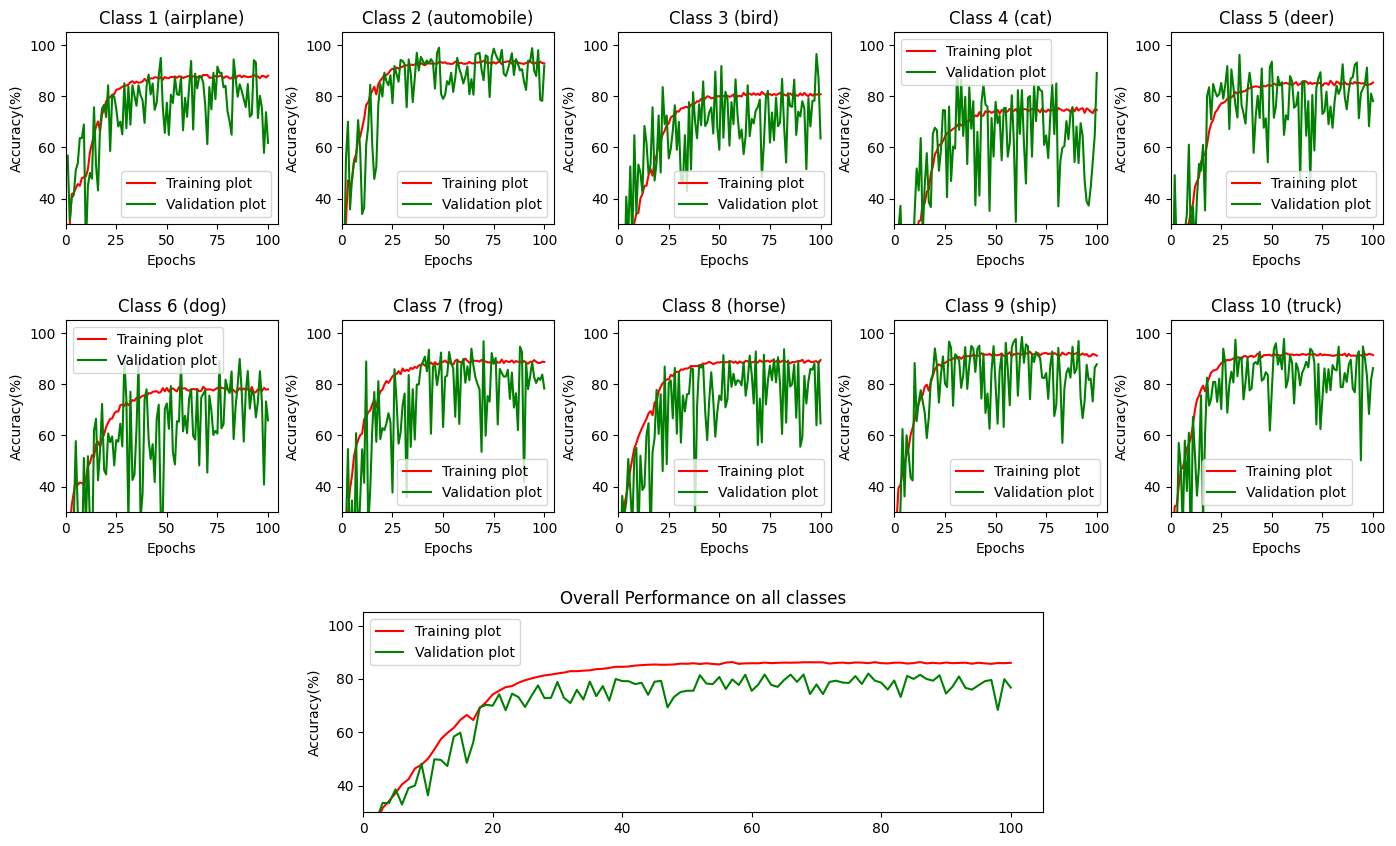

In [41]:
plot_curves(train_logs,val_logs,True,save_pth +'/dataaug_l2reg_cnn')